In [1]:
import os
from IPython.core.interactiveshell import InteractiveShell
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
InteractiveShell.ast_node_interactivity = "all"

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)
pd.options.display.max_rows


In [2]:
ROOT = 'BatDongSan'
PATH_DATA = os.path.join(ROOT, 'chotot.csv')


In [3]:
df = pd.read_csv(PATH_DATA)


In [4]:
[*df.columns]


['id',
 'list_time',
 'type_real_estate',
 'ward',
 'area',
 'region',
 'address',
 'property_status',
 'price_m2',
 'direction',
 'balconydirection',
 'property_legal_document',
 'size',
 'floornumber',
 'apartment_type',
 'furnishing_sell',
 'apartment_feature',
 'rooms',
 'toilets',
 'floors',
 'house_type',
 'living_size',
 'width',
 'length',
 'land_type',
 'property_road_condition',
 'land_feature',
 'property_back_condition',
 'price']

In [5]:
import DataPreProcessor as DPP

In [6]:
p = DPP.DataPreProcessor(df)

# Drop thuộc tính id và price_m2
p.drop_column(['id', 'price_m2'])

# Xóa các dòng bị missing của hai thuộc tính là price và list_time
p.drop_row_nan(['price'])
p.drop_row_nan(['list_time'])

# Chuyển thời gian timestamp thành date
p.convert_timestamp_to_date('list_time')

# Tách lấy số của thuộc tính rooms và toilets
p.split_number('rooms', 'toilets')


In [7]:
type_ = ['apartment_type', 'house_type', 'land_type']
# Thay thế các giá trị nan của type_ bằng "" để chuẩn hóa giá trị
df[type_] = df[type_].replace(np.nan, '')


In [8]:
# Merge các thuộc tính có các loại giá trị riêng biệt thành 1 thuộc tính chung
p.merge_column('ahl_type', type_)

# Drop các thuộc tính đã merge
p.drop_column(type_)

In [9]:
df.head()


,list_time,type_real_estate,ward,area,region,address,property_status,direction,balconydirection,property_legal_document,size,floornumber,furnishing_sell,apartment_feature,rooms,toilets,floors,living_size,width,length,property_road_condition,land_feature,property_back_condition,price,ahl_type
0,05/11/2021,Căn hộ/Chung cư,Phường Tam Hòa,Thành phố Biên Hòa,Đồng Nai,"Đường Đồng Khởi, Phường Tam Hòa, Thành phố Biên Hòa, Đồng Nai",Đã bàn giao,NaN,NaN,Đang chờ sổ,70 m²,NaN,NaN,NaN,2,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.150000e+09,Chung cư
1,05/11/2021,Căn hộ/Chung cư,Phường Thống Nhất,Thành phố Biên Hòa,Đồng Nai,"Đường Võ Thị Sáu, Phường Thống Nhất, Thành phố Biên Hòa, Đồng Nai",Đã bàn giao,Bắc,Nam,Đã có sổ,48 m²,NaN,Nội thất đầy đủ,NaN,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.550000e+09,Chung cư
2,05/11/2021,Căn hộ/Chung cư,Phường Hố Nai,Thành phố Biên Hòa,Đồng Nai,"368 Đường Xa Lộ Hà Nội, Phường Hố Nai, Thành phố Biên Hòa, Tỉnh Đồng Nai., Phường Hố Nai, Thành phố Biên Hòa, Đồng Nai",Chưa bàn giao,NaN,NaN,Giấy tờ khác,67 m²,NaN,Hoàn thiện cơ bản,NaN,2,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.600000e+08,Chung cư
3,05/11/2021,Căn hộ/Chung cư,Phường Hố Nai,Thành phố Biên Hòa,Đồng Nai,"368 Đường Xa Lộ Hà Nội, Phường Hố Nai, Thành phố Biên Hòa, Tỉnh Đồng Nai., Phường Hố Nai, Thành phố Biên Hòa, Đồng Nai",Chưa bàn giao,NaN,NaN,Đã có sổ,70 m²,NaN,NaN,NaN,2,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.700000e+09,Chung cư
4,05/11/2021,Căn hộ/Chung cư,Phường Thống Nhất,Thành phố Biên Hòa,Đồng Nai,"Đường Võ Thị Sáu, Phường Thống Nhất, Thành phố Biên Hòa, Đồng Nai",Đã bàn giao,NaN,NaN,Đã có sổ,48 m²,NaN,NaN,NaN,2,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000e+07,Chung cư


In [10]:
# Kiểm tra đơn vị của thuộc tính size
unit_unique = p.check_unique_unit('size')
print(unit_unique)
# Đổi các đơn vị của thuộc tính size về cùng một đơn vị theo một tỷ lệ
unit_convert = [1, 1, 10000]
p.convert_to_same_unit('size', unit_unique, unit_convert,
                       add_unit_name=True, unit_name='m2')


['m²', 'm2', 'hecta']


In [11]:
# Kiểm tra đơn vị của thuộc tính living_size
unit_unique = p.check_unique_unit('living_size')
print(unit_unique)
# Đổi các đơn vị của thuộc tính living_size về cùng một đơn vị theo một tỷ lệ
unit_convert = [1]
p.convert_to_same_unit('living_size', unit_unique,
                       unit_convert, add_unit_name=True, unit_name='m2')


['m²']


In [12]:
# Kiểm tra đơn vị của thuộc tính width
unit_unique = p.check_unique_unit('width')
print(unit_unique)
# Đổi các đơn vị của thuộc tính width về cùng một đơn vị theo một tỷ lệ
unit_convert = [1]
p.convert_to_same_unit('width', unit_unique, unit_convert,
                       add_unit_name=True, unit_name='m')


['m']


In [13]:
# Kiểm tra đơn vị của thuộc tính length
unit_unique = p.check_unique_unit('length')
print(unit_unique)
# Đổi các đơn vị của thuộc tính length về cùng một đơn vị theo một tỷ lệ
unit_convert = [1]
p.convert_to_same_unit('length', unit_unique, unit_convert,
                       add_unit_name=True, unit_name='m')


['m']


In [14]:
# Chuyển đổi giá của thuộc tính size từ đơn vị đồng về triệu
p.convert_unit('price', 1000000, add_unit_name=True, unit_name='million')


In [15]:
# Xuất ra file csv
p.save_as_csv('chotot_cleaned.csv')


In [16]:
p.data.describe()


,size (m2),floornumber,living_size (m2),width (m),length (m),price (million)
count,9.525700e+04,3876.000000,42737.000000,73725.000000,72877.000000,9.540900e+04
mean,3.093060e+04,12.199690,166.610159,21.722333,41.086344,1.826762e+07
std,4.411510e+06,12.160109,1126.917752,1207.894713,898.128423,5.640653e+09
min,1.000000e+00,1.000000,1.000000,1.000000,1.000000,3.700000e-01
25%,5.079000e+01,6.000000,64.000000,4.000000,12.000000,1.773000e+03
50%,7.200000e+01,10.000000,100.000000,5.000000,16.000000,3.450000e+03
75%,1.120000e+02,17.000000,180.000000,6.000000,22.000000,6.100000e+03
max,9.000000e+08,456.000000,123456.000000,315375.000000,135000.000000,1.742304e+12


In [17]:
for column in p.data.columns:
    print('Feature:', column)
    print(p.data[column].unique())
    print('\n')


Feature: list_time
['05/11/2021' '04/11/2021' '03/11/2021' '02/11/2021' '01/11/2021'
 '31/10/2021' '30/10/2021' '29/10/2021' '28/10/2021' '27/10/2021'
 '26/10/2021' '25/10/2021' '24/10/2021' '23/10/2021' '22/10/2021'
 '21/10/2021' '20/10/2021' '19/10/2021' '18/10/2021' '17/10/2021'
 '16/10/2021' '15/10/2021' '14/10/2021' '13/10/2021' '12/10/2021'
 '11/10/2021' '10/10/2021' '09/10/2021' '08/10/2021' '07/10/2021'
 '06/10/2021' '05/10/2021' '04/10/2021' '03/10/2021' '01/10/2021'
 '30/09/2021' '29/09/2021' '28/09/2021' '27/09/2021' '26/09/2021'
 '25/09/2021' '24/09/2021' '23/09/2021' '22/09/2021' '21/09/2021'
 '18/09/2021' '17/09/2021' '16/09/2021' '15/09/2021' '13/09/2021'
 '10/09/2021' '09/09/2021' '08/09/2021' '07/09/2021' '06/09/2021'
 '16/08/2021' '02/10/2021' '20/09/2021' '19/09/2021' '14/09/2021'
 '12/09/2021' '11/09/2021' '13/08/2021' '31/07/2021' '24/05/2021'
 '11/05/2021' '13/04/2021' '11/04/2021' '07/04/2021' '28/03/2021'
 '26/03/2021' '27/05/2020' '14/08/2021' '03/09/2021' '28/

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt


def visualizing_missing_data(df):
    missing_values = df.isnull().sum() / len(df)
    # missing_values = missing_values[missing_values > 0]
    # missing_values.sort_values(inplace=True)
    missing_values = missing_values.to_frame()
    missing_values.columns = ['ratio']
    missing_values.index.names = ['feature']
    missing_values['feature'] = missing_values.index
    print(missing_values)
    plt.figure(figsize=(10, 10))
    sns.set(style="whitegrid", color_codes=False)
    sns.barplot(x='feature', y='ratio', data=missing_values)
    plt.xticks(rotation=90)
    plt.show()


                            ratio                  feature
feature                                                   
list_time                0.000000                list_time
type_real_estate         0.000000         type_real_estate
ward                     0.000241                     ward
area                     0.000021                     area
region                   0.000000                   region
address                  0.000293                  address
property_status          0.863346          property_status
direction                0.661458                direction
balconydirection         0.954878         balconydirection
property_legal_document  0.140050  property_legal_document
size (m2)                0.001593                size (m2)
floornumber              0.959375              floornumber
furnishing_sell          0.725749          furnishing_sell
apartment_feature        0.969804        apartment_feature
rooms                    0.288243                    roo

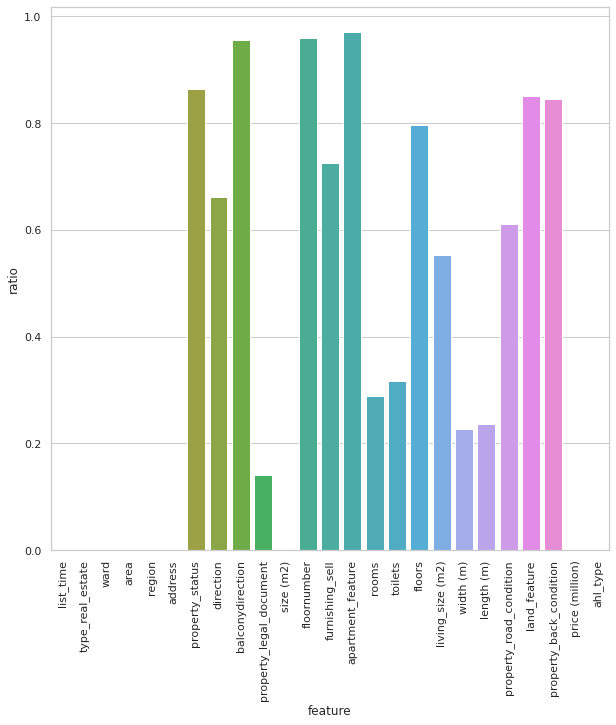

In [19]:
visualizing_missing_data(df)
